In [50]:
import pandas as pd

df = pd.read_csv("combined_dataset.csv", parse_dates=["index"], index_col="index")
df.sort_index(inplace=True)          # ensure chronological order
df.head()


,stage_m,pres,temp,rhum,wspd,prcp
index,,,,,,
1995-10-01,1.96,1021.18,17.63,82.83,8.01,0.0
1995-10-02,1.93,1018.78,17.85,83.46,6.87,0.0
1995-10-03,1.91,1015.09,17.94,93.92,8.40,0.3
1995-10-04,3.79,1011.30,16.96,98.79,5.57,87.2
1995-10-05,5.41,1002.01,20.36,91.67,25.63,59.5


In [51]:
df.info()           # types & non-null counts
df.describe()       # mean, std, quartiles
df.isna().sum()     # missing-value tally


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10837 entries, 1995-10-01 to 2025-06-01
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   stage_m  10788 non-null  float64
 1   pres     10837 non-null  float64
 2   temp     10837 non-null  float64
 3   rhum     10837 non-null  float64
 4   wspd     10837 non-null  float64
 5   prcp     10837 non-null  float64
dtypes: float64(6)
memory usage: 592.6 KB


stage_m    49
pres        0
temp        0
rhum        0
wspd        0
prcp        0
dtype: int64

In [52]:
# rows whose stage height is NaN
missing_rows = df[df['stage_m'].isna()]
print(f"{missing_rows.shape[0]} gaps:\n", missing_rows.index)


49 gaps:
 DatetimeIndex(['1996-08-27', '1996-08-28', '1997-09-06', '1997-09-07',
               '2000-07-03', '2000-07-04', '2000-07-05', '2000-07-06',
               '2000-07-07', '2000-07-12', '2000-07-13', '2000-07-14',
               '2003-09-27', '2003-09-28', '2003-09-29', '2004-02-02',
               '2004-02-03', '2004-02-05', '2004-02-18', '2004-02-19',
               '2004-09-08', '2004-09-09', '2004-09-10', '2005-06-18',
               '2005-06-19', '2005-06-20', '2005-06-21', '2005-06-26',
               '2005-06-27', '2005-06-28', '2005-06-29', '2005-07-16',
               '2005-07-17', '2005-07-18', '2005-07-21', '2005-07-22',
               '2005-07-23', '2005-07-24', '2005-07-25', '2005-12-15',
               '2019-02-28', '2021-10-31', '2021-11-04', '2021-11-05',
               '2021-11-07', '2021-11-08', '2024-09-27', '2024-09-28',
               '2024-09-29'],
              dtype='datetime64[ns]', name='index', freq=None)


In [53]:
# consecutive-gap detector
gaps        = df['stage_m'].isna()
gap_blocks  = (gaps != gaps.shift()).cumsum()[gaps]          # label runs
gap_lengths = gap_blocks.value_counts().sort_index()

display(gap_lengths.rename('days'))          # how long is each run?


stage_m
2     2
4     2
6     5
8     3
10    3
12    2
14    1
16    2
18    3
20    4
22    4
24    3
26    5
28    1
30    1
32    1
34    2
36    2
38    3
Name: days, dtype: int64

In [54]:
# 0. provenance column
df['stage_gap_flag'] = df['stage_m'].isna().astype(int)

# 1. fill 1–2-day gaps (fast sensor hiccups)
df['stage_m'] = (df['stage_m']
                   .ffill(limit=1)   # cover 1-day holes
                   .bfill(limit=1))  # symmetrical

# 2. spline for anything still NaN (3–5-day blocks)
df['stage_m'] = df['stage_m'].interpolate(method='spline',
                                          order=3,
                                          limit_direction='both')


In [55]:
# rows whose stage height is NaN
missing_rows = df[df['stage_m'].isna()]
print(f"{missing_rows.shape[0]} gaps:\n", missing_rows.index)


0 gaps:
 DatetimeIndex([], dtype='datetime64[ns]', name='index', freq=None)


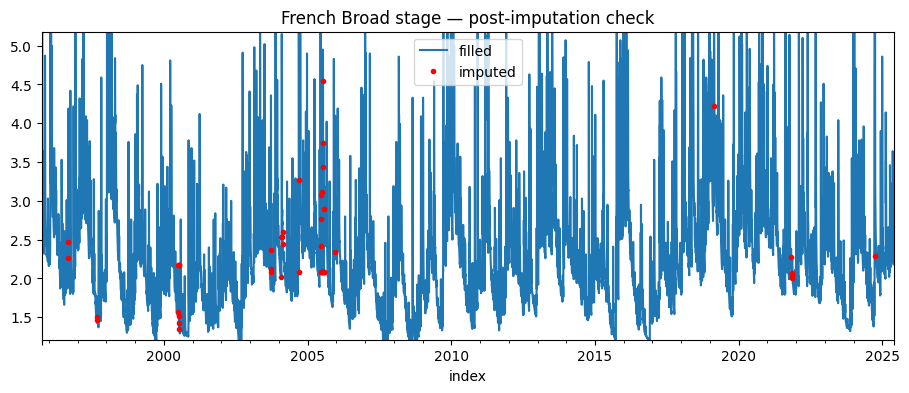

In [56]:
import matplotlib.pyplot as plt
ax = df['stage_m'].plot(figsize=(11,4), label='filled')
df.loc[df.stage_gap_flag==1, 'stage_m'].plot(style='ro', ms=3, ax=ax,
                                             label='imputed')
ax.set_title('French Broad stage — post-imputation check')
ax.set_ylim(df['stage_m'].quantile(0.01), df['stage_m'].quantile(0.99))
ax.legend(); plt.show()


In [57]:
df_daily = df.resample("D").mean()             # impose daily grid
df_daily["missing_flag"] = df_daily.isna().any(axis=1).astype(int)


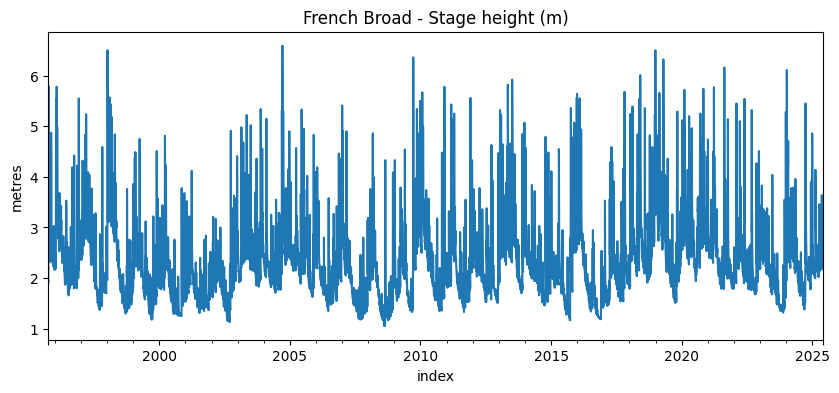

In [58]:
import matplotlib.pyplot as plt
df_daily["stage_m"].plot(figsize=(10,4), title="French Broad - Stage height (m)")
plt.ylabel("metres"); plt.show()


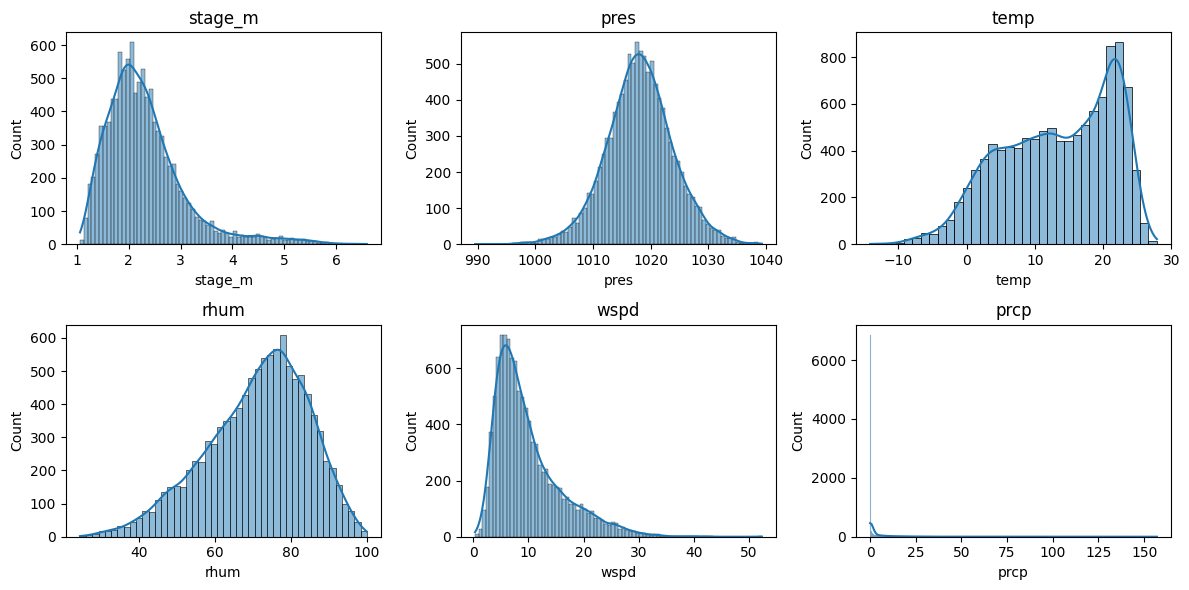

In [59]:
import seaborn as sns
fig, axes = plt.subplots(2,3, figsize=(12,6))
for ax, col in zip(axes.flat, df.columns):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()


In [60]:
stats = df.describe().T[[ 'min','25%','50%','75%','max','mean','std']]
display(stats)


,min,25%,50%,75%,max,mean,std
stage_m,1.06,1.80,2.16,2.62,6.59,2.305043,0.773653
pres,989.56,1014.50,1018.10,1021.71,1039.25,1018.105868,5.766212
temp,-14.14,6.97,14.30,20.67,27.90,13.365075,8.045311
rhum,24.50,62.58,72.92,81.00,100.00,71.170412,13.353580
wspd,0.32,5.55,8.12,12.61,52.35,9.891769,6.039887
prcp,0.00,0.00,0.00,2.50,157.00,3.867724,9.836574
stage_gap_flag,0.00,0.00,0.00,0.00,1.00,0.004522,0.067093


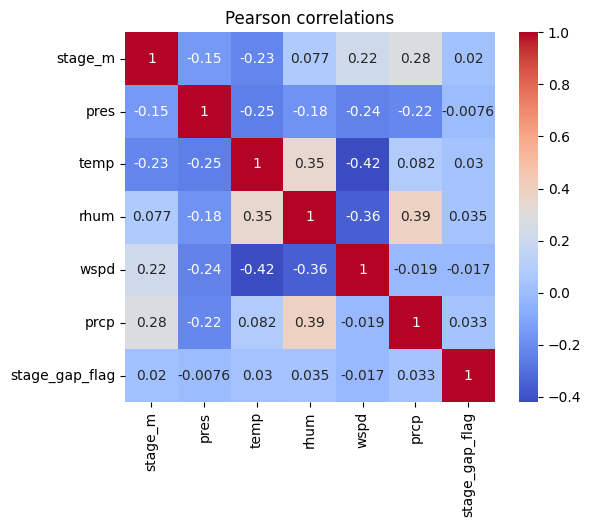

In [61]:
import seaborn as sns, matplotlib.pyplot as plt
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", square=True)
plt.title("Pearson correlations"); plt.show()


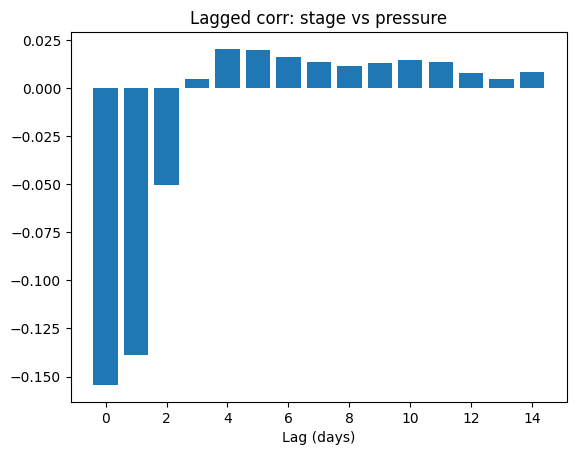

In [62]:
from scipy.signal import correlate
max_lag = 14
xcorr = [df['stage_m'].corr(df['pres'].shift(l)) for l in range(max_lag+1)]
plt.bar(range(max_lag+1), xcorr); plt.xlabel("Lag (days)")
plt.title("Lagged corr: stage vs pressure"); plt.show()


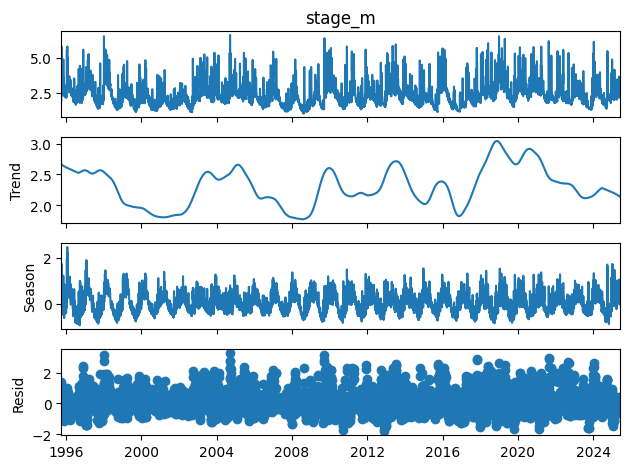

In [63]:
from statsmodels.tsa.seasonal import STL
stl = STL(df['stage_m'], period=365)
res = stl.fit()
res.plot(); plt.show()


In [64]:
from statsmodels.tsa.stattools import adfuller
print("ADF p-value:", adfuller(df['stage_m'].dropna())[1])


ADF p-value: 4.0686402405340565e-12


In [65]:
q1,q3 = df['stage_m'].quantile([.25,.75]); iqr = q3-q1
outlier_mask = (df['stage_m'] < q1-1.5*iqr) | (df['stage_m'] > q3+1.5*iqr)
df['outlier_flag'] = outlier_mask.astype(int)


In [66]:
df.to_csv("french_broad_clean.csv", index=True)
